In [1]:
%load_ext autoreload
%autoreload 3
from common import preprocess, read_data
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from scipy import interpolate
from imblearn.over_sampling import SMOTE

In [2]:
loans = read_data()
print("Total incoming", len(loans))
processed = preprocess(loans, keep_percent=0.1)
print("Length of processed", len(processed))

approved = np.array(processed["approved"])
gender = np.array(processed["applicant_sex"])
race = np.array(processed["applicant_race"])
X_unsampled = processed.drop(["approved", "applicant_sex", "applicant_race"], axis=1)
total_columns = len(X_unsampled.columns)
print("Total columns", total_columns)

Total incoming 1714459
Length of processed 98762
Total columns 19


In [3]:

output_dim = 5
loss_fn = nn.CrossEntropyLoss()
y_unsampled = race

print("Using Multi Cross Entropy")
def calc_loss(output, labels):
    output_multi = torch.tensor(output)
    output_multi = torch.argmax(output_multi, axis=1)
    return loss_fn(output_multi.float(), labels.float())

def calc_accurracy(outputs, labels):

    preds = torch.argmax(outputs.clone().detach(), 1).float()
    corrects = (preds == labels.clone().float().detach())
    # acc = corrects.float().mean()
    acc = sum(
        preds.cpu().numpy().round() == labels.clone().detach().cpu().numpy()
    ) / len(outputs)
    # ret_acc = acc.cpu().detach().numpy()
    # print("Preds", preds)
    # print("Labels", labels)
    # print("Corrects", corrects)
    # print("ACC:", acc)
    # print(ret_acc)
    return acc

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X_unsampled, y_unsampled)

X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_tv, y_tv, test_size=0.60, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_valid = sc.transform(X_valid)

Using Multi Cross Entropy


In [8]:
scaled = pd.DataFrame(sc.transform(X), columns=X.columns)

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class LoanDataset(Dataset):

    def __init__(self, x, y):

        self.x_train=torch.tensor(x, dtype=torch.float32)
        self.y_train=torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

dataset = LoanDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=100, shuffle=False)
dataset = LoanDataset(X_test, y_test)
test_loader = DataLoader(dataset, batch_size=100, shuffle=False)
dataset = LoanDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset, batch_size=100, shuffle=False)
del dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

input_dim = total_columns
learning_rate = 0.005

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p=0.05)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(self.relu(self.hidden2(x)))
        x = self.dropout(self.relu(self.hidden3(x)))
        x = self.sigmoid(self.output(x))
        return x

model = NeuralNetwork().to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 275
loss_values = []
acc_values = []

losses = []
all_accs = []
val_accs = []
for i in range(num_epochs):
    model.train(True)
    accs = []
    for j, (xinputs, ylabels) in enumerate(train_loader):

        xinputs, ylabels = xinputs.to(device), ylabels.to(device)

        #calculate output
        output = model(xinputs)

        #calculate loss
        # loss = loss_fn(output, ylabels.reshape(-1,1))
        loss = calc_loss(output, ylabels)

        # calc accuracy
        accs.append(calc_accurracy(output, ylabels))

        #backprop
        optimizer.zero_grad()
        loss.requires_grad = True
        loss.backward()
        optimizer.step()

    acc_epoch = sum(accs)/len(accs)

    # Calculate validation
    model.train(False)
    vacc = 0
    for k, (vinputs, vlabels) in enumerate(valid_loader):
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = calc_loss(voutputs, vlabels)
        vacc += calc_accurracy(voutputs, vlabels)

    vacc_epoch = vacc/k

    losses.append(float(loss))
    all_accs.append(acc_epoch)
    val_accs.append(vacc_epoch)
    print("epoch {}\tloss : {}\tacc: {}".format(i, loss, acc_epoch))
    print("epoch {}\tvloss : {}\tvacc: {}\n".format(i, vloss, vacc_epoch))

print("Training Complete")


Using cuda device
NeuralNetwork(
  (hidden1): Linear(in_features=19, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


C:\Users\Matt\AppData\Local\Temp\ipykernel_11232\3295802733.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_multi = torch.tensor(output)


epoch 0	loss : 186.71343994140625	acc: 0.20313380281690147
epoch 0	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 1	loss : 186.918212890625	acc: 0.20346097417840417
epoch 1	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 2	loss : 178.71343994140625	acc: 0.20320569248826312
epoch 2	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 3	loss : 180.2634735107422	acc: 0.20298122065727758
epoch 3	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 4	loss : 189.11672973632812	acc: 0.2033289319248833
epoch 4	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 5	loss : 185.11672973632812	acc: 0.20306778169014134
epoch 5	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 6	loss : 186.71343994140625	acc: 0.20284771126760617
epoch 6	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 7	loss : 186.71343994140625	acc: 0.20338028169014094
epoch 7	vloss : 401.82476806640625	vacc: 0.20259149440867458

epoch 8	loss : 180.2634735107422	acc

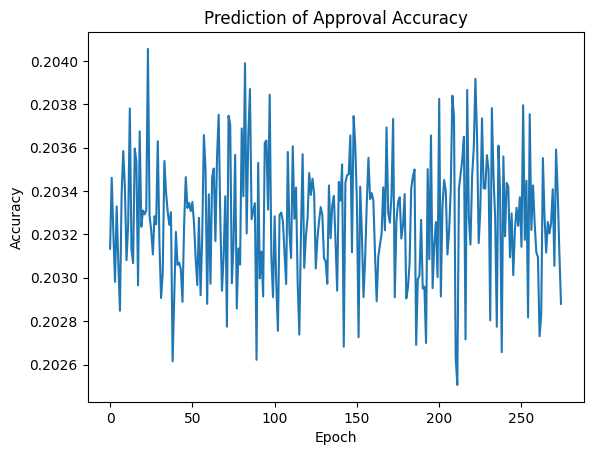

In [6]:
plt.plot(all_accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Prediction of Approval Accuracy")

plt.show()

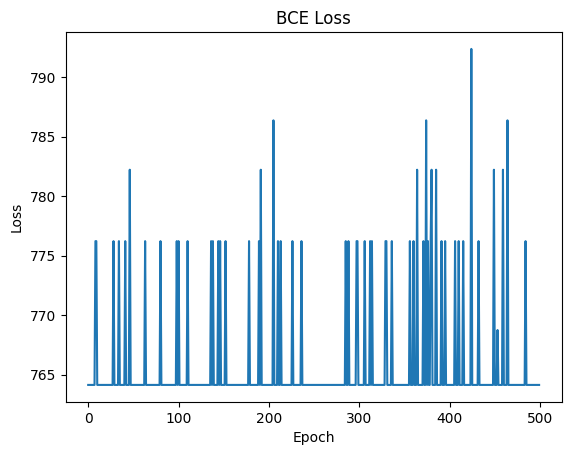

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BCE Loss")
plt.show()